#### This notebook is used to train a character recongition from input image using MobileNets 

In [1]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

### Visualize dataset

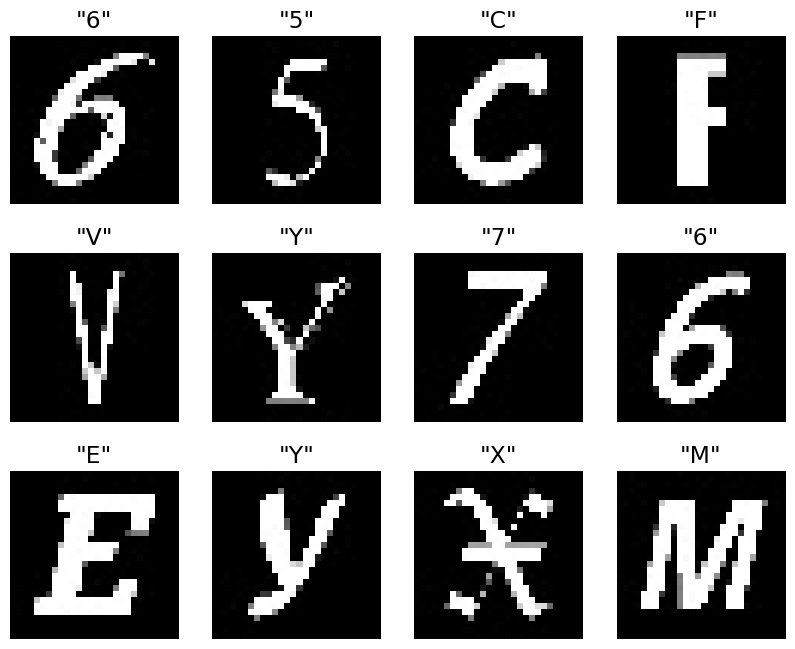

In [2]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)    


## Data pre-processing

In [3]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 37623 images with 36 classes


In [5]:
# split 30% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [7]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

## Initialize MobileNets architecture with pre-trained weight

In [18]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
from tensorflow.keras.optimizers import Adam

# Create our model with pre-trained MobileNetV2 architecture from imagenet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(learning_rate=1e-4, decay_steps=10000, decay_rate=0.9, training=False, output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet",
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    if training:
        # Define trainable layers
        for layer in baseModel.layers:
            layer.trainable = True

        # Create a learning rate schedule with exponential decay
        learning_rate_schedule = ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate
        )

        # Create an optimizer with the learning rate schedule
        optimizer = Adam(learning_rate=learning_rate_schedule)
        
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model



In [21]:
# initilaize initial hyperparameter
from tensorflow.keras.optimizers import Adam

# Initialize initial hyperparameters
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(learning_rate=INIT_LR, training=True)


## Train model

In [22]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
529/529 [==============================] - ETA: 0s - loss: 1.5652 - accuracy: 0.5893
Epoch 1: saving model to License_character_recognition.h5
529/529 [==============================] - 906s 2s/step - loss: 1.5652 - accuracy: 0.5893 - val_loss: 1.7852 - val_accuracy: 0.5695
Epoch 2/30
529/529 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8809
Epoch 2: saving model to License_character_recognition.h5
529/529 [==============================] - 885s 2s/step - loss: 0.4486 - accuracy: 0.8809 - val_loss: 0.4910 - val_accuracy: 0.8740
Epoch 3/30
529/529 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.9166
Epoch 3: saving model to License_character_recognition.h5
529/529 [==============================] - 824s 2s/step - loss: 0.3055 - accuracy: 0.9166 - val_loss: 0.2070 - val_accuracy: 0.9418
Epoch 4/30
529/529 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.9339
Epoch 4: saving model to License_character_rec

## Visualize training result

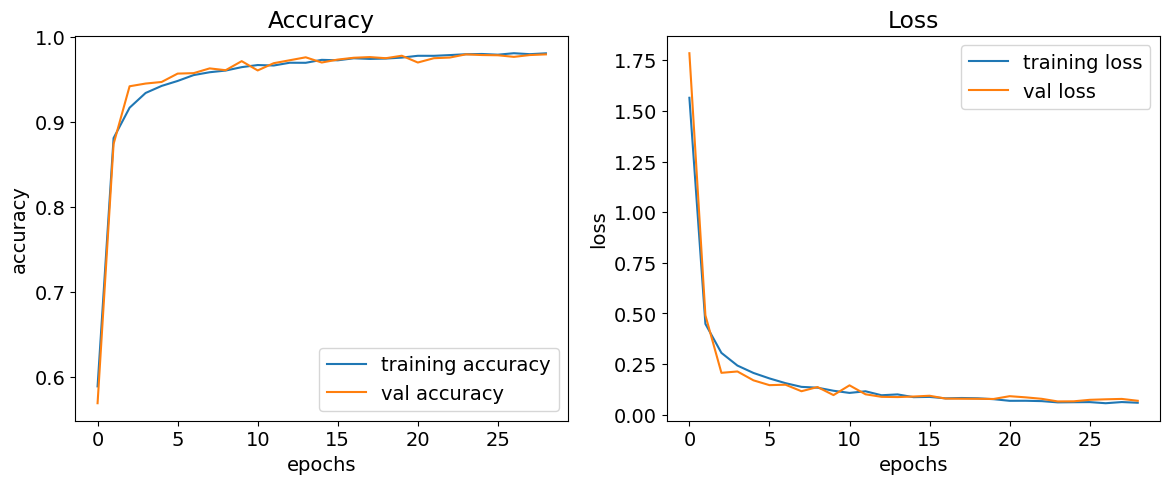

In [23]:

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#plt.savefig("Training_result.jpg",dpi=300)

In [17]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition.json", "w") as json_file:
    json_file.write(model_json)